In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import warnings
import math

from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

from xgboost import XGBRegressor, XGBClassifier

from sklearn import set_config
set_config(display = 'diagram')
# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.cluster import KMeans

In [23]:
users_df = pd.read_csv('../raw_data/users.csv')
# centers_df = pd.read_csv('../raw_data/distribution_centers.csv')
events_df = pd.read_csv('../raw_data/events.csv')
inventory_items_df = pd.read_csv('../raw_data/inventory_items.csv')
order_items_df = pd.read_csv('../raw_data/order_items.csv')
orders_df = pd.read_csv('../raw_data/orders.csv')
products_df = pd.read_csv('../raw_data/products.csv')

## basic join

In [3]:
def join_tables_item_level(order_items_df, products_df):
    '''
    Joins order-item & product
    '''
    order_items_df = order_items_df[['id', 
                                     'order_id', 
                                     'user_id', 
                                     'product_id', 
                                     'inventory_item_id',
                                     'status', 
                                     'created_at', 
                                     # 'shipped_at', 
                                     # 'delivered_at', 
                                     # 'returned_at',
                                     'sale_price']].rename(columns={'id':'order_item_id','status':'order_status'})    

    order_items_df['created_at'] = pd.to_datetime(order_items_df['created_at'],
                                                       format='mixed').dt.tz_localize(None)
    products_df = products_df[['id', 
                               'cost', 
                               'category', 
                               'name',
                               'brand',
                               'retail_price', 
                               'department',
                               # 'sku',
                               'distribution_center_id']]

    
    df_joined = order_items_df.merge(products_df, left_on='product_id', right_on='id', how='left')
    df_joined = df_joined.drop(columns=['id']) # duplicate product id    

    return df_joined

## Data Exploration

array([[<Axes: title={'center': 'created_at'}>]], dtype=object)

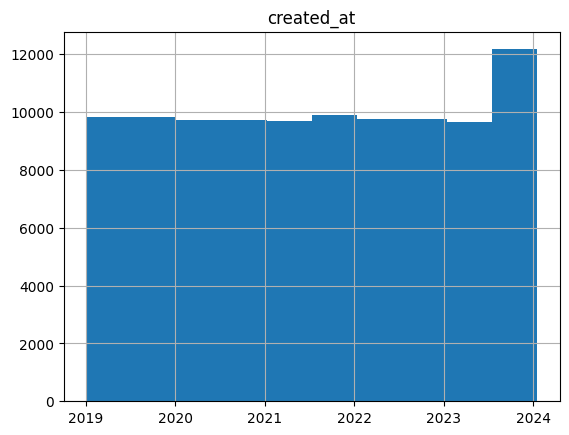

In [4]:
# Check users
users_df_test = users_df.copy()
users_df_test['created_at'] = pd.to_datetime(users_df_test['created_at'],format='mixed').dt.tz_localize(None)
users_df_test.hist('created_at')

array([[<Axes: title={'center': 'created_at'}>]], dtype=object)

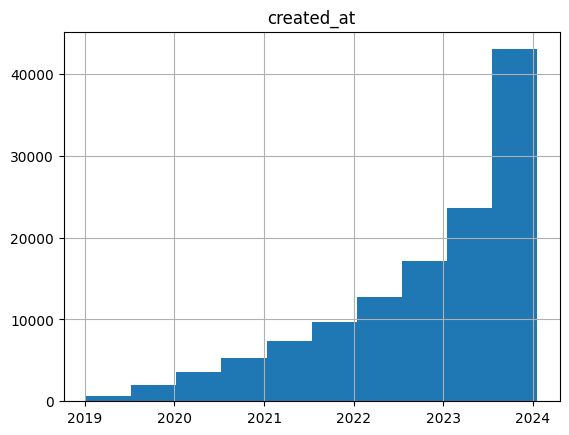

In [5]:
# Check order trend
orders_test = orders_df.copy()
orders_test['created_at'] = pd.to_datetime(orders_test['created_at'],format='mixed').dt.tz_localize(None)
orders_test.hist('created_at')

<Axes: >

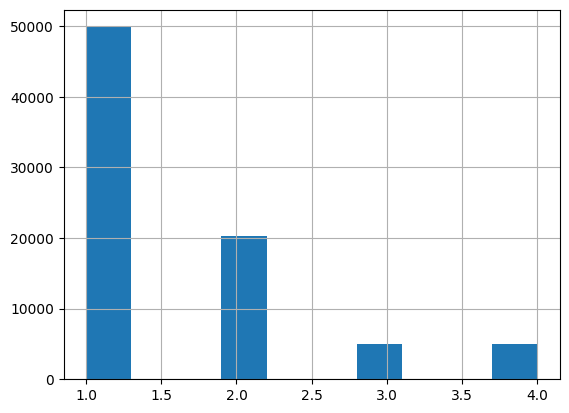

In [6]:
orders_cnt = orders_test.groupby(by='user_id')['order_id'].count().reset_index(name='orders')

orders_cnt['orders'].hist()

# Most of users only buy once

In [ ]:
users_test = orders_df.copy()
users_test['created_at'] = pd.to_datetime(users_test['created_at'],format='mixed').dt.tz_localize(None)

In [ ]:
users_test['year'] = users_test.created_at.dt.year

#### ? Users sign up early and buy later somehow

In [ ]:
orders_w_user = orders_test.merge(users_test[['user_id','created_at']].rename(columns={'created_at':'user_created_at'}), on='user_id')

In [ ]:
orders_w_user['months_from_signup'] = (orders_w_user.created_at-orders_w_user.user_created_at).dt.days/30

In [ ]:
orders_w_user.months_from_signup.hist()

# user_created_at is wrong

In [ ]:
orders_df.columns

#### ? Is there brands working bad in terms of return rate?

In [ ]:
item_product_df = join_tables_item_level(order_items_df, products_df)

In [ ]:
item_product_df['num_returns'] = item_product_df.

In [ ]:
item_product_df.groupby(by=['brand','order_status'])['order_id'].nunique().reset_index()

## Data Prep

In [ ]:
orders_test_df = orders_df.copy()

# datetime format cast
dt_columns = [ 'created_at', 'returned_at', 'shipped_at', 'delivered_at']

for column in dt_columns:
    orders_test_df[column] = pd.to_datetime(orders_test_df[column],format='mixed').dt.tz_localize(None)

# First order only
orders_test_df['order_rank'] = orders_test_df.groupby('user_id')['created_at'].rank(method='first').astype(int)
orders_df_first = orders_test_df[orders_test_df.order_rank == 1].copy()

In [ ]:
orders_df_first.groupby(by='user_id')['order_id'].count().value_counts()

In [ ]:
orders_df_first.groupby(by='user_id')['order_id'].count().value_counts()

In [9]:
orders_df.status.value_counts()

status
Shipped       37577
Complete      31354
Processing    25156
Cancelled     18609
Returned      12530
Name: count, dtype: int64

In [10]:
def first_order_calc(orders_df):
    '''
    ---
    '''

    # datetime format cast
    dt_columns = [ 'created_at', 'returned_at', 'shipped_at', 'delivered_at']

    for column in dt_columns:
        orders_df[column] = pd.to_datetime(orders_df[column],format='mixed').dt.tz_localize(None)

    # Calc delivery day
    orders_df['delivery_days'] = (orders_df['delivered_at'] - orders_df['created_at']).dt.days

    # First order only
    orders_df['order_rank'] = orders_df.groupby('user_id')['created_at'].rank(method='first').astype(int)
    orders_df_first = orders_df[orders_df.order_rank == 1].copy()

    # second onwards
    orders_df_future = orders_df[orders_df.order_rank > 1].copy()
    orders_df_future = orders_df_future.groupby('user_id')['order_id'].count().reset_index(name='future_orders')
    # # information about first orders
    # orders_df_first['delivery_days'] = (orders_df_first)

    result = orders_df_first.merge(orders_df_future, on='user_id', how='left')

    return result

In [22]:
orders_df.columns

Index(['order_id', 'user_id', 'status', 'gender', 'created_at', 'returned_at',
       'shipped_at', 'delivered_at', 'num_of_item', 'delivery_days',
       'order_rank', 'order_rank_prev'],
      dtype='object')

In [36]:
def restructure_orders_prev_next(orders_df):
    '''
    ---
    '''

    # datetime format cast
    dt_columns = [ 'created_at', 'returned_at', 'shipped_at', 'delivered_at']

    for column in dt_columns:
        orders_df[column] = pd.to_datetime(orders_df[column],format='mixed').dt.tz_localize(None)

    # Calc delivery day
    orders_df['delivery_days'] = (orders_df['delivered_at'] - orders_df['created_at']).dt.days

    # First order only
    orders_df['order_rank'] = orders_df.groupby('user_id')['created_at'].rank(method='first').astype(int)

    # Next orders
    orders_next = orders_df.copy()
    orders_next['order_rank_prev'] = orders_next['order_rank']-1
    orders_next = orders_next[['user_id','order_id','order_rank_prev']].rename(columns={'order_id':'next_order_id'})
    
    orders_prev_next = orders_df.merge(orders_next, left_on=['user_id','order_rank'], right_on=['user_id','order_rank_prev'], how='left')

    orders_prev_next['next_order?'] = orders_prev_next['next_order_id'].notna()

    return orders_prev_next.drop(columns='order_rank_prev')

In [37]:
restructure_orders_prev_next(orders_df)

,order_id,user_id,status,gender,created_at,returned_at,shipped_at,delivered_at,num_of_item,delivery_days,order_rank,next_order_id,next_order?
0,8,5,Cancelled,F,2022-10-20 10:03:00,NaT,NaT,NaT,3,NaN,1,NaN,False
1,60,44,Cancelled,F,2023-01-20 02:12:00,NaT,NaT,NaT,1,NaN,1,59.0,True
2,64,46,Cancelled,F,2021-12-06 09:11:00,NaT,NaT,NaT,1,NaN,2,NaN,False
3,89,65,Cancelled,F,2020-08-13 09:58:00,NaT,NaT,NaT,1,NaN,1,NaN,False
4,102,76,Cancelled,F,2023-01-17 08:17:00,NaT,NaT,NaT,2,NaN,2,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125221,125196,99972,Shipped,M,2022-06-25 11:56:00,NaT,2022-06-28 08:24:00,NaT,1,NaN,1,NaN,False
125222,125199,99975,Shipped,M,2022-07-20 02:19:00,NaT,2022-07-22 11:08:00,NaT,4,NaN,1,NaN,False
125223,125208,99983,Shipped,M,2022-03-14 15:06:00,NaT,2022-03-17 05:15:00,NaT,1,NaN,1,125209.0,True
125224,125210,99983,Shipped,M,2023-03-01 15:06:00,NaT,2023-03-02 10:50:00,NaT,2,NaN,3,125211.0,True


In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the Earth's surface given their latitude and longitude
    in decimal degrees.
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371  # Radius of Earth in kilometers. Use 3956 for miles
    return c * r

## Join item level dataframe into one

In [ ]:
def join_tables_item_level(order_items_df, products_df):
    '''
    Joins order-item & product
    '''
    order_items_df = order_items_df[['id', 
                                     'order_id', 
                                     'user_id', 
                                     'product_id', 
                                     'inventory_item_id',
                                     # 'status', 
                                     'created_at', 
                                     # 'shipped_at', 
                                     # 'delivered_at', 
                                     # 'returned_at',
                                     'sale_price']].rename(columns={'id':'order_item_id'})

    

    order_items_df['created_at'] = pd.to_datetime(order_items_df['created_at'],
                                                       format='mixed').dt.tz_localize(None)
    products_df = products_df[['id', 
                               'cost', 
                               'category', 
                               'name',
                               'brand',
                               'retail_price', 
                               'department',
                               # 'sku',
                               'distribution_center_id']]

    
    df_joined = order_items_df.merge(products_df, left_on='product_id', right_on='id', how='left')
    df_joined = df_joined.drop(columns=['id']) # duplicate product id    

    return df_joined

## - Joined Dataframe Aggregation
### -- Calculates preffered brand and category

In [ ]:
def product_info(item_level_df):
    '''
    takes item-level dataframe and calculate features to user level.
    '''

    base = item_level_df[['order_id','order_item_id']].groupby('order_id').count().fillna(0).rename(columns={'order_item_id':'num_order_item'}).reset_index()

    # order revenue
    revenue = item_level_df.groupby(by='order_id')['sale_price'].sum().reset_index(name='sale_price')
    base = base.merge(revenue, on='order_id', how='left') 
    
    # order retail_price
    revenue = item_level_df.groupby(by='order_id')['retail_price'].sum().reset_index(name='retail_price')
    base = base.merge(revenue, on='order_id', how='left') 
    
    
    # Most frequent category
    count_cat = item_level_df.groupby(['order_id', 'category']).size().reset_index(name='count')
    # Find the index of the row with the maximum count for each user
    max_count_index = count_cat.groupby('order_id')['count'].idxmax()
    # Extract the rows corresponding to the maximum counts
    preferred_categories = count_cat.loc[max_count_index]
    # remove duplicates
    pref_cat_no_duplicates = preferred_categories.drop_duplicates(subset=['order_id']).rename(columns={'category':'category_preffered'})

    base = base.merge(pref_cat_no_duplicates[['order_id','category_preffered']],on='order_id',how='left')            


    # Department
    # Most frequent category
    count_dept = item_level_df.groupby(['order_id', 'department']).size().reset_index(name='count')
    # Find the index of the row with the maximum count for each user
    max_count_index_dept = count_dept.groupby('order_id')['count'].idxmax()
    # Extract the rows corresponding to the maximum counts
    preferred_dept = count_dept.loc[max_count_index_dept]
    # remove duplicates
    pref_dept_no_duplicates = preferred_dept.drop_duplicates(subset=['order_id']).rename(columns={'department':'dept_pref'})

    base = base.merge(pref_dept_no_duplicates[['order_id','dept_pref']],on='order_id',how='left')    
    
    return base

## User dataset

In [ ]:
# users_df.groupby('age')['id'].nunique()

In [ ]:
def select_user_columns(users_df):

    df = users_df[['id','age','country','created_at','traffic_source']].rename(columns={'id':'user_id','created_at':'user_created_at'})
    # Filter users only for last 2 years from split date
    # min_date = split_date - pd.DateOffset(days=365*5)

    def assign_age_group(age):
        if age <= 15:
            return '00_15'
        elif age <= 25:
            return '16_25'
        elif age <= 35:
            return '26_35'
        elif age <= 45:
            return '36_45'
        elif age <= 55:
            return '46_55'
        else:
            return '56_99'

    df['age_group'] = df['age'].apply(assign_age_group)
    
    return df

## Y Actual

In [ ]:
# def create_y_actual(order_items_df, split_date, days_predict):
#     df = order_items_df[['id','user_id','created_at','sale_price']].copy().rename(columns={'id':'order_item_id'})
#     df['order_created_at'] = pd.to_datetime(df['created_at'], format='mixed').dt.tz_localize(None)

#     # select next 90 days of revenue from split_date
#     max_date = split_date + pd.DateOffset(days=days_predict)
#     df = df[(df['order_created_at'] <= max_date) & (df['order_created_at'] > split_date)]
    
#     df_agg = df[['user_id','sale_price']].groupby('user_id').sum().fillna(0).rename(columns={'sale_price':'future_clv'})

#     return df_agg

## Event Dataset

In [ ]:
events_df.event_type.value_counts()

In [ ]:
def event_dataset(events_df):
    '''
    Returns most used browser per user_id
    '''
    
    events_df = events_df[events_df['user_id'].notna()].copy()
    events_df['created_at'] = pd.to_datetime(events_df['created_at'], format='mixed').dt.tz_localize(None)
    
    # Preffered browser
    count_browser = events_df.groupby(['user_id', 'browser']).size().reset_index(name='count')
    max_count_index = count_browser.groupby('user_id')['count'].idxmax()
    preferred_browser = count_browser.loc[max_count_index]
    pref_brsr_no_duplicates = preferred_browser.drop_duplicates(subset=['user_id']).rename(columns={'browser':'browser_pref'})
    base = pref_brsr_no_duplicates[['user_id','browser_pref']]

    return base

In [ ]:
item_level_df = join_tables_item_level(order_items_df, products_df)

In [ ]:
df_user = select_user_columns(users_df)
df_order = first_order_calc(orders_df)
df_item = product_info(item_level_df)
df_event = event_dataset(events_df)

In [ ]:
temp_event = events_df[['id', 'user_id','session_id', 'created_at', 'event_type']].rename(columns={'id':'event_id','created_at':'event_created_at'})
# temp_users = users_df[['id', 'age', 'gender', 'country']].rename(columns={'id':'user_id'})
temp_order = orders_df[['order_id', 'user_id', 'status', 'created_at', 'delivered_at', 'order_rank']]

In [ ]:
temp_order.merge(temp_event, on='user_id', how='left') 

## Testing to create user-event dataset

In [ ]:
order_event_jd = orders_df[['order_id', 'created_at']].merge(events_df[[]], on='user_id', how='left')

In [ ]:
order_event_jd.head(10)

## Checking if there are any duplicates

In [ ]:
df_user.user_id.count(), df_user.user_id.nunique()

In [ ]:
df_order.user_id.count(), df_order.user_id.nunique()

In [ ]:
df_item.order_id.count(), df_item.order_id.nunique()

In [ ]:
df_event.user_id.count(), df_event.user_id.nunique()

## Join all the prepped datasets

In [ ]:
def prep_input_dataset(df_user, df_order, df_item, df_event):
    '''
    joins all preprocessed user-level-df
    '''
    
    final_df = df_order.merge(df_user, on='user_id', how='left')
    final_df = final_df.merge(df_item, on='order_id', how='left')
    final_df = final_df.merge(df_event, on='user_id', how='left').reset_index()

    return final_df


In [ ]:
input_dataset = prep_input_dataset(df_user, df_order, df_item, df_event)

In [ ]:
input_dataset['future_orders']=input_dataset['future_orders'].fillna(0).copy()
input_dataset['sale_ratio'] = input_dataset['sale_price']/input_dataset['retail_price']

In [ ]:
input_dataset.columns

## Define X, y

In [ ]:
# List of columns to drop
columns_to_drop = ['user_id','index','order_id','order_rank','num_order_item','future_orders','created_at','returned_at','shipped_at','delivered_at'
                   ,'user_created_at']

X = input_dataset.drop(columns=columns_to_drop).copy()
y = input_dataset['future_orders'].fillna(0).copy()

In [ ]:
y_binary = y.apply(lambda x: 1 if x > 0 else 0)

In [ ]:
feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

corr_num = X[feat_numerical].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_num, cmap='coolwarm',vmin=-1, vmax=1);

In [ ]:
X.columns

In [ ]:
X.shape, y.shape

In [ ]:
X.select_dtypes(include='object').nunique()

In [ ]:
y_binary.hist()

## Preprocessor Pipelines

In [ ]:
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler()
)

preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)


preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_categorical_baseline, make_column_selector(dtype_include=["object"])),
    remainder="drop"
)

preproc_baseline

In [ ]:
test = preproc_baseline.fit_transform(X)
test.shape

## Model Selection

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

In [ ]:
pipe_tree = make_pipeline(preproc_baseline, DecisionTreeClassifier())
pipe_tree

In [ ]:
score_baseline = cross_val_score(pipe_tree, X_train, y_train, cv=5, scoring='accuracy').mean()

score_baseline

In [ ]:
pipe_randomforest = make_pipeline(preproc_baseline, RandomForestClassifier())
pipe_randomforest

In [ ]:
# takes very long time!!!!!!!!! result = 0.8623132669939197
score_randomforest = cross_val_score(pipe_randomforest, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
score_randomforest

### Other models

In [ ]:
# # Ridge with normal target
# model = Ridge()
# pipe_ridge = make_pipeline(preproc_baseline, model)
# cross_val_score(pipe_ridge, X, y, cv=5, scoring='r2').mean()

In [ ]:
# # Ridge with normal target
# model = KNeighborsRegressor()
# pipe_knn = make_pipeline(preproc_baseline, model)
# cross_val_score(pipe_knn, X, y, cv=5, scoring='r2').mean()

In [ ]:
# Taking too long - giving up
# model = SVR(kernel='rbf', C = 10)
# pipe_svm_rbf = make_pipeline(preproc_baseline, model)
# cross_val_score(pipe_svm_rbf, X, y, cv=5, scoring='r2').mean()

In [ ]:
# # ADA Boost

# model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=None))
# pipe_ada_boost = make_pipeline(preproc_baseline, model)
# score = cross_val_score(pipe_ada_boost, X, y, cv=5, scoring='r2')

## Fit, Predict, Evaluate

In [ ]:
pipe_randomforest.fit(X_train, y_train)

In [ ]:
y_randomforest = pipe_randomforest.predict(X_test)

In [ ]:
(y_randomforest.sum(), y_test.sum())

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Assuming y_test contains the actual labels
accuracy = accuracy_score(y_test, y_randomforest)
precision = precision_score(y_test, y_randomforest)
recall = recall_score(y_test, y_randomforest)
f1 = f1_score(y_test, y_randomforest)
conf_matrix = confusion_matrix(y_test, y_randomforest)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

In [ ]:
# Get the Random Forest model from the pipeline
rf_model = pipe_randomforest.named_steps['randomforestclassifier']

# Access feature importance from the Random Forest model
feature_importance = rf_model.feature_importances_

# Get the transformed feature names from OneHotEncoder
one_hot_encoder = preproc_baseline.named_transformers_['pipeline-2']['onehotencoder']

# Get the feature names after one-hot encoding
encoded_columns = one_hot_encoder.get_feature_names_out()

In [ ]:
# Get the original numerical column names
numerical_columns = preproc_baseline.named_transformers_['pipeline-1']['simpleimputer'].get_feature_names_out()

# Concatenate the numerical column names with the one-hot encoded column names
all_column_names = list(numerical_columns) + list(encoded_columns)

# Ensure that the length of the concatenated list matches the length of the feature_importance array
assert len(all_column_names) == len(feature_importance), "Lengths of column names and feature importance values do not match"

In [ ]:
# Pair feature importance scores with corresponding column names
feature_importance_df = pd.DataFrame({'Feature': all_column_names, 'Importance': feature_importance})

# Sort the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance')
plt.show()

## Save model

In [ ]:
import pickle

In [ ]:
# Define the filename for your .pkl file
filename = '../clv_the_look/training/rf_model_v0.pkl'

# Save the trained model to a .pkl file
with open(filename, 'wb') as file:
    pickle.dump(pipe_randomforest, file)

## Try KNN

In [ ]:
test_country_event = events_df.groupby(by='user_id')['traffic_source'].nunique().reset_index()

In [ ]:
event_types_list = ['product','cart','department','purchase','cancel','home']

for idx, type in enumerate(event_types_list):
    print(idx, type)

In [ ]:
def cluster_event_df(events_df):
    '''
    Returns most used browser per user_id
    '''
    
    events_df = events_df[events_df['user_id'].notna()].copy()
    events_df['created_at'] = pd.to_datetime(events_df['created_at'], format='mixed').dt.tz_localize(None)

    # base
    base = events_df.groupby('user_id')['session_id'].nunique().reset_index(name='sessions')
    
    # Preffered browser
    count_browser = events_df.groupby(['user_id', 'browser']).size().reset_index(name='count')
    max_count_index = count_browser.groupby('user_id')['count'].idxmax()
    preferred_browser = count_browser.loc[max_count_index]
    pref_brsr_no_duplicates = preferred_browser.drop_duplicates(subset=['user_id']).rename(columns={'browser':'browser_pref'})
    base = base.merge(pref_brsr_no_duplicates[['user_id','browser_pref']],on='user_id',how='left')

    # types of events
    event_types_list = ['product','cart','department','purchase','cancel','home']
    
    for type in event_types_list:
        column_ = type + '_counts'
        user_behaviour = events_df[events_df['event_type']==type].groupby(by='user_id')['session_id'].nunique().reset_index(name=column_)
        base = base.merge(user_behaviour, on='user_id', how='left')
    
    
    return base

In [ ]:
select_user_columns(users_df)

In [ ]:
item_product_df.created_at.dt.year

In [ ]:
def cluser_item_product_agg(item_product_df):
    '''
    to user level
    '''

    base = item_level_df[['user_id','order_item_id']].groupby('user_id').count().fillna(0).rename(columns={'order_item_id':'num_order_items'}).reset_index()
    
    # order revenue
    revenue = item_level_df.groupby(by='user_id')['sale_price'].sum().reset_index(name='total_sales')
    base = base.merge(revenue, on='user_id', how='left') 
    
    # order retail_price
    retail_price = item_level_df.groupby(by='user_id')['retail_price'].sum().reset_index(name='total_retail_price')
    base = base.merge(retail_price, on='user_id', how='left') 

    # total_orders
    total_orders = item_level_df.groupby(by='user_id')['order_id'].nunique().reset_index(name='total_orders')
    base = base.merge(total_orders, on='user_id', how='left')

    # total_brands
    total_brands = item_level_df.groupby(by='user_id')['brand'].nunique().reset_index(name='total_num_brands')
    base = base.merge(total_brands, on='user_id', how='left')

    # firt order created at year, month
    year = item_level_df.groupby(by='user_id')['created_at'].min().reset_index(name='min_order_created_at')
    year['min_order_created_year'] = year.min_order_created_at.dt.year
    year['min_order_created_month'] = year.min_order_created_at.dt.month
    base = base.merge(year, on='user_id', how='left')

    base['abv'] = base.total_sales / base.total_orders

    # total_period
    max_date = item_level_df['created_at'].max()
    base['customer_T'] = (max_date - base['min_order_created_at']).dt.days
    
    
    
    # Most frequent category
    count_cat = item_level_df.groupby(['user_id', 'category']).size().reset_index(name='count')
    # Find the index of the row with the maximum count for each user
    max_count_index = count_cat.groupby('user_id')['count'].idxmax()
    # Extract the rows corresponding to the maximum counts
    preferred_categories = count_cat.loc[max_count_index]
    # remove duplicates
    pref_cat_no_duplicates = preferred_categories.drop_duplicates(subset=['user_id']).rename(columns={'category':'category_preffered'})

    base = base.merge(pref_cat_no_duplicates[['user_id','category_preffered']],on='user_id',how='left')            


    # Department
    # Most frequent category
    count_dept = item_level_df.groupby(['user_id', 'department']).size().reset_index(name='count')
    # Find the index of the row with the maximum count for each user
    max_count_index_dept = count_dept.groupby('user_id')['count'].idxmax()
    # Extract the rows corresponding to the maximum counts
    preferred_dept = count_dept.loc[max_count_index_dept]
    # remove duplicates
    pref_dept_no_duplicates = preferred_dept.drop_duplicates(subset=['user_id']).rename(columns={'department':'dept_pref'})

    base = base.merge(pref_dept_no_duplicates[['user_id','dept_pref']],on='user_id',how='left')    
    
    return base

In [ ]:
item_product_df = join_tables_item_level(order_items_df, products_df)

In [ ]:
test = cluser_item_product_agg(item_product_df)

## Data Prep for Clustering

In [ ]:
user_prep = select_user_columns(users_df)
event_prep = cluster_event_df(events_df)
item_product_df = join_tables_item_level(order_items_df, products_df)
order_prep = cluser_item_product_agg(item_product_df)

In [ ]:
## Join all of them

input_prep = user_prep.copy()
input_prep = input_prep.merge(event_prep, on='user_id', how='left')
input_prep = input_prep.merge(order_prep, on='user_id', how='left')

columns_excl = ['user_id','user_created_at','min_order_created_at','min_order_created_at']

input_prep = input_prep.drop(columns=columns_excl)
input_prep.info()

In [ ]:
input_prep.isna().sum()

In [ ]:
input_prep['total_orders'].value_counts()

## preprocessing, fit, predict

In [ ]:
km_input = preproc_baseline.fit_transform(input_prep)

In [ ]:
prepped_values = pd.DataFrame(km_input.toarray())

In [ ]:
sns.heatmap(prepped_values.corr(), cmap='coolwarm')

In [ ]:
km_input.shape

In [ ]:
km = KMeans(n_clusters=4)
km.fit(km_input)

In [ ]:
cluster_labels= km.predict(km_input)
cluster_labels

In [ ]:
centroids = km.cluster_centers_
centroids.shape

In [ ]:
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_counts = dict(zip(unique, counts))
print(cluster_counts)

## Trying DeepLearning

In [ ]:
''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Normalization
from tensorflow.keras.metrics import Recall, Precision


In [ ]:
X.head()

In [ ]:
# Preprocess
X_t = preproc_baseline.fit_transform(X)

In [ ]:
X_t.toarray()

In [ ]:
# Train test split before any resampling to keep real test set
X_train, X_test, y_train, y_test = train_test_split(X_t, y_binary, test_size = 0.3)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3)

In [ ]:
X_train = X_train.toarray()
X_val = X_val.toarray()

In [ ]:
# How many "fraud" samples do I have in each split?
print(np.sum(y_train[y_train == 1]))
print(np.sum(y_val[y_val == 1]))
print(np.sum(y_test[y_test == 1]))

print("-"*100)

print(f"There are {pd.Series(y_train).value_counts()[1]} purchased users in the train set")
print(f"There are {pd.Series(y_val).value_counts()[1]} purchased users in the val set")
print(f"There are {pd.Series(y_test).value_counts()[1]} purchased users in the test set")

In [ ]:
print(X_train.shape)
print(X_val.shape)

## Neural Network Iteration

In [ ]:
metrics = [
    keras.metrics.Recall(name='recall'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]

In [ ]:
X_train.shape

In [ ]:
def init_model():
    input_shape = X_train.shape[1:]
    # normalizer = Normalization()
    # normalizer.adapt(X_train)
    
    model = models.Sequential()
    # model.add()
    model.add(layers.Dense(64, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    # Model compilation
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=metrics)
    return model

## Regularized model

In [ ]:
[X_train.shape, y_train.shape]

In [ ]:
[X_val.shape, y_val.shape]

In [ ]:
model = init_model()

es = EarlyStopping(
    patience=10,
    monitor='val_recall', 
    restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=4,
                    callbacks=[es], shuffle=True)

In [ ]:
def plot_loss_precision_recall_curve(history):
    
    fig, ax =plt.subplots(1,3,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- RECALL

    ax[1].plot(history.history['recall'])
    ax[1].plot(history.history['val_recall'])
    ax[1].set_title('Model recall', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    
    # --- PRECISION
    
    
    ax[2].plot(history.history['precision'])
    ax[2].plot(history.history['val_precision'])
    ax[2].set_title('Model precision', fontsize = 18)
    ax[2].set_xlabel('Epoch', fontsize = 14)
    ax[2].set_ylabel('Precision', fontsize = 14)
    ax[2].legend(['Train', 'Val'], loc='lower right')  
    ax[2].grid(axis="x",linewidth=0.5)
    ax[2].grid(axis="y",linewidth=0.5)    
    
    plt.show()

In [ ]:
plot_loss_precision_recall_curve(history)

## Score it

In [ ]:
model.evaluate(X_test, y_test, verbose=0, return_dict=True)

In [ ]:
y_pred_proba = model.predict(X_test)

In [ ]:
threshold = 0.50 # 50% 

y_pred_binary = np.where(y_pred_proba > threshold, 1, 0 )

## Confusion Matrix

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_binary)
cm

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_binary))

In [ ]:
from sklearn.metrics import precision_recall_curve

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    plt.plot(recall, precision, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:
plot_prc("Test", y_test, y_pred_proba, linestyle='--')
plt.legend(loc='lower right')